## Gradient Class Activation Map

### Library Import

In [3]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2

import torch
from torch import nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision import transforms as T

from tqdm import tqdm
import albumentations as A
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import utils

/Users/wasuratsoontronchai/opt/anaconda3/envs/torch-vision/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Configurations

In [65]:
CSV_FILE = './GradCAM-Dataset/train.csv'
DATA_DIR = './GradCAM-Dataset/'

DEVICE = 'cpu'
BATCH_SIZE = 16
LR = 0.0005
EPOCHS = 50

SEED_NUM = 42

In [12]:
# Read in data labelling file
# Cucumber - 0, Eggaplat - 1, Mushroom - 2
data = pd.read_csv(CSV_FILE)
data.head()

,img_path,label
0,train_images/mushroom_51.jpg,2
1,train_images/eggplant_37.jpg,1
2,train_images/mushroom_20.jpg,2
3,train_images/eggplant_51.jpg,1
4,train_images/eggplant_26.jpg,1


In [17]:
train_df, valid_df = train_test_split(data, test_size = 0.2, random_state = SEED_NUM)

### Image Augmentations

In [66]:
train_augs = A.Compose([
                A.Rotate(),
                A.HorizontalFlip(p = 0.5),
                A.VerticalFlip(p = 0.5),
                A.Normalize(mean = [0.485, 0.456, 0.406],
                            std = [0.229, 0.224, 0.225])
                ])

valid_augs = A.Compose([
                A.Normalize(mean = [0.485, 0.456, 0.406],
                            std = [0.229, 0.224, 0.225])
                ])

### Image Dataset

In [95]:
trainset = utils.ImageDataset(train_df, augs = train_augs, data_dir = DATA_DIR)
validset = utils.ImageDataset(valid_df, augs = train_augs, data_dir = DATA_DIR)

trainset_noaugs = utils.ImageDataset(train_df, data_dir = DATA_DIR)
validset_noaugs = utils.ImageDataset(valid_df, data_dir = DATA_DIR)

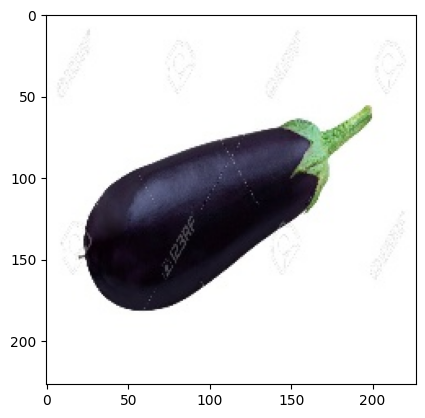

In [96]:
image_noaug, label = validset_noaugs[4]
plt.imshow(image_noaug.permute(1, 2, 0)) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'eggplant')

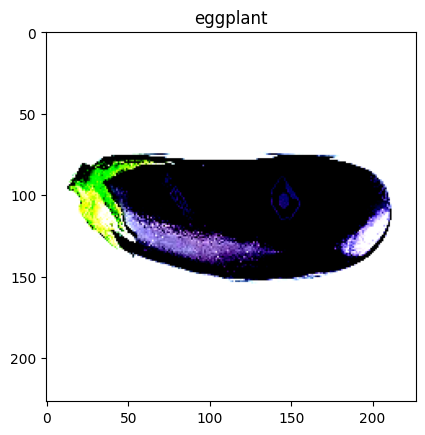

In [69]:
image, label = trainset[0]
class_list = ['cucumber', 'eggplant', 'mushroom']

plt.imshow(image.permute(1, 2, 0))
plt.title(class_list[label])

In [70]:
print(f"No. of examples in the {len(trainset)}")
print(f"No. of examples in the {len(validset)}")

No. of examples in the 148
No. of examples in the 38


### Load dataset to batch

In [71]:
train_loader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
valid_loader = DataLoader(validset, batch_size = BATCH_SIZE)

In [72]:
print(f"No. of batches in train loader = {len(train_loader)}")
print(f"No. of batches in validate loader = {len(valid_loader)}")

for images, labels in train_loader:
    break

print(f"One batch image shape : {images.shape}")
print(f"One batch label shape : {labels.shape}")

No. of batches in train loader = 10
No. of batches in validate loader = 3
One batch image shape : torch.Size([16, 3, 227, 227])
One batch label shape : torch.Size([16])


### Model Class

In [86]:
from torch.nn.modules.pooling import MaxPool2d

class ImageModel(nn.Module):
    def __init__(self):
        super(ImageModel, self).__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels= 3, out_channels= 16, kernel_size= (5, 5), padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size= (4,4), stride= 2),

            nn.Conv2d(in_channels= 16, out_channels= 16, kernel_size= (5, 5), padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size= (4,4), stride= 2),

            nn.Conv2d(in_channels= 16, out_channels= 32, kernel_size= (5, 5), padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size= (4,4), stride= 2),

            nn.Conv2d(in_channels= 32, out_channels= 64, kernel_size= (5, 5), padding = 1),
            nn.ReLU()
        )

        self.maxpool = nn.MaxPool2d(kernel_size= (4, 4), stride =2)
        self.classifer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(6400, 2048),
            nn.ReLU(),
            nn.Linear(2048, 3)
        )
        self.gradient = None
        
    def activations_hook(self, grad):
        self.gradient = grad

    def forward(self, images):
        x = self.feature_extractor(images)
        h = x.register_hook(self.activations_hook)
        x = self.maxpool(x) 
        x = self.classifer(x)
        return x

    def get_activation_gradients(self):
        return self.gradient

    def get_activation(self, x):
        return self.feature_extractor(x)

In [87]:
model = ImageModel()
model.to(DEVICE)

ImageModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=(4, 4), stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=6400, out_features=2048, bias=True)
    (2): ReLU()
    (3): Linear(in_features=2048, out_features=3, bias=True)
  )
)

### Train & Evaluation Function

In [88]:
def train_fn(dataloader, model, optimizer, criterion):

    model.train()
    total_loss = 0.0

    for image, labels in tqdm(dataloader):
        images = image.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()

        optimizer.step()
        total_loss += loss.item()

    return total_loss/len(dataloader)

def eval_fn(dataloader, model, criterion):

    model.eval()
    total_loss = 0.0

    for image, labels in tqdm(dataloader):
        images = image.to(DEVICE)
        labels = labels.to(DEVICE)

        logits = model(images)
        loss = criterion(logits, labels)

        total_loss += loss.item()

    return total_loss/len(dataloader)
        

### Trainig Loop

In [89]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)
criterion = torch.nn.CrossEntropyLoss()

best_valid_loss = np.Inf
for i in range(EPOCHS):
    train_loss = train_fn(train_loader, model, optimizer, criterion)
    valid_loss = eval_fn(valid_loader, model, criterion)

    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), f'best_model_weight.pt')
        best_valid_loss = valid_loss
        print("SAVED_WEIGHTS_SUCCESS")
        
    print(f"EPOCH : {i + 1} TRAIN LOSS : {train_loss} VALID LOSS : {valid_loss}")

100%|██████████| 3/3 [00:00<00:00,  7.66it/s]


SAVED_WEIGHTS_SUCCESS
EPOCH : 1 TRAIN LOSS : 1.1483290433883666 VALID LOSS : 1.0834731260935466


100%|██████████| 3/3 [00:00<00:00,  8.44it/s]


SAVED_WEIGHTS_SUCCESS
EPOCH : 2 TRAIN LOSS : 0.9462391376495362 VALID LOSS : 0.6765408913294474


100%|██████████| 3/3 [00:00<00:00,  8.57it/s]


SAVED_WEIGHTS_SUCCESS
EPOCH : 3 TRAIN LOSS : 0.6135006904602051 VALID LOSS : 0.5780029197533926


100%|██████████| 3/3 [00:00<00:00,  8.73it/s]


SAVED_WEIGHTS_SUCCESS
EPOCH : 4 TRAIN LOSS : 0.3666379310190678 VALID LOSS : 0.19730495661497116


100%|██████████| 3/3 [00:00<00:00,  8.75it/s]


SAVED_WEIGHTS_SUCCESS
EPOCH : 5 TRAIN LOSS : 0.22907359153032303 VALID LOSS : 0.16844254235426584


100%|██████████| 3/3 [00:00<00:00,  8.85it/s]


EPOCH : 6 TRAIN LOSS : 0.3029862567782402 VALID LOSS : 0.5957151452700297


100%|██████████| 3/3 [00:00<00:00,  8.83it/s]


EPOCH : 7 TRAIN LOSS : 0.32319205701351167 VALID LOSS : 0.3944244980812073


100%|██████████| 3/3 [00:00<00:00,  8.87it/s]


SAVED_WEIGHTS_SUCCESS
EPOCH : 8 TRAIN LOSS : 0.1821341510862112 VALID LOSS : 0.16790452599525452


100%|██████████| 3/3 [00:00<00:00,  8.83it/s]


SAVED_WEIGHTS_SUCCESS
EPOCH : 9 TRAIN LOSS : 0.10865382887423039 VALID LOSS : 0.15759382334848246


100%|██████████| 3/3 [00:00<00:00,  8.75it/s]


SAVED_WEIGHTS_SUCCESS
EPOCH : 10 TRAIN LOSS : 0.07350099622562993 VALID LOSS : 0.12413721283276875


100%|██████████| 3/3 [00:00<00:00,  8.53it/s]


SAVED_WEIGHTS_SUCCESS
EPOCH : 11 TRAIN LOSS : 0.03123847075039521 VALID LOSS : 0.08382837722698848


100%|██████████| 3/3 [00:00<00:00,  8.60it/s]


EPOCH : 12 TRAIN LOSS : 0.027825434814440088 VALID LOSS : 0.4894602653221227


100%|██████████| 3/3 [00:00<00:00,  8.51it/s]


EPOCH : 13 TRAIN LOSS : 0.042633812491840214 VALID LOSS : 0.13390676397830248


100%|██████████| 3/3 [00:00<00:00,  8.40it/s]


EPOCH : 14 TRAIN LOSS : 0.06144615823286585 VALID LOSS : 0.6123329425851504


100%|██████████| 3/3 [00:00<00:00,  8.60it/s]


EPOCH : 15 TRAIN LOSS : 0.11375106209889055 VALID LOSS : 0.5174224761625131


100%|██████████| 3/3 [00:00<00:00,  8.56it/s]


EPOCH : 16 TRAIN LOSS : 0.08939479440450668 VALID LOSS : 0.31814279158910114


100%|██████████| 3/3 [00:00<00:00,  8.27it/s]


EPOCH : 17 TRAIN LOSS : 0.38262440022081134 VALID LOSS : 0.4884818394978841


100%|██████████| 3/3 [00:00<00:00,  8.38it/s]


EPOCH : 18 TRAIN LOSS : 0.21412346018478273 VALID LOSS : 0.17431370665629706


100%|██████████| 3/3 [00:00<00:00,  8.50it/s]


SAVED_WEIGHTS_SUCCESS
EPOCH : 19 TRAIN LOSS : 0.09197554402053357 VALID LOSS : 0.08171578046555321


100%|██████████| 3/3 [00:00<00:00,  8.54it/s]


SAVED_WEIGHTS_SUCCESS
EPOCH : 20 TRAIN LOSS : 0.020729005802422762 VALID LOSS : 0.03089490548397104


100%|██████████| 3/3 [00:00<00:00,  8.52it/s]


EPOCH : 21 TRAIN LOSS : 0.018352767956093884 VALID LOSS : 0.0639363534670944


100%|██████████| 3/3 [00:00<00:00,  8.36it/s]


EPOCH : 22 TRAIN LOSS : 0.08238747256509668 VALID LOSS : 0.09037526270064215


100%|██████████| 3/3 [00:00<00:00,  8.62it/s]


EPOCH : 23 TRAIN LOSS : 0.14905897148419173 VALID LOSS : 0.9348329761996865


100%|██████████| 3/3 [00:00<00:00,  8.74it/s]


SAVED_WEIGHTS_SUCCESS
EPOCH : 24 TRAIN LOSS : 0.05975333428941667 VALID LOSS : 0.019882255233824253


100%|██████████| 3/3 [00:00<00:00,  8.59it/s]


EPOCH : 25 TRAIN LOSS : 0.018912769356393255 VALID LOSS : 0.034967251461542524


100%|██████████| 3/3 [00:00<00:00,  8.66it/s]


EPOCH : 26 TRAIN LOSS : 0.004694806865882128 VALID LOSS : 0.2551651589989585


100%|██████████| 3/3 [00:00<00:00,  8.58it/s]


EPOCH : 27 TRAIN LOSS : 0.013791288206994068 VALID LOSS : 0.48072936589596793


100%|██████████| 3/3 [00:00<00:00,  8.25it/s]


EPOCH : 28 TRAIN LOSS : 0.07906700732055469 VALID LOSS : 0.08840324145664151


100%|██████████| 3/3 [00:00<00:00,  8.05it/s]


EPOCH : 29 TRAIN LOSS : 0.0796524312478141 VALID LOSS : 0.6640801679556413


100%|██████████| 3/3 [00:00<00:00,  7.75it/s]


EPOCH : 30 TRAIN LOSS : 0.07155585609616537 VALID LOSS : 0.37098942572871846


100%|██████████| 3/3 [00:00<00:00,  7.54it/s]


EPOCH : 31 TRAIN LOSS : 0.04633625103160739 VALID LOSS : 0.5484736850485206


100%|██████████| 3/3 [00:00<00:00,  7.54it/s]


EPOCH : 32 TRAIN LOSS : 0.021085804293397813 VALID LOSS : 0.13098965717169145


100%|██████████| 3/3 [00:00<00:00,  7.47it/s]


EPOCH : 33 TRAIN LOSS : 0.03716198543552309 VALID LOSS : 0.4150871727615595


100%|██████████| 3/3 [00:00<00:00,  7.61it/s]


EPOCH : 34 TRAIN LOSS : 0.01772090908307291 VALID LOSS : 0.043584944175866745


100%|██████████| 3/3 [00:00<00:00,  7.55it/s]


EPOCH : 35 TRAIN LOSS : 0.015338132582837716 VALID LOSS : 0.037020166113507


100%|██████████| 3/3 [00:00<00:00,  7.48it/s]


EPOCH : 36 TRAIN LOSS : 0.015400151292351439 VALID LOSS : 0.23389425625403723


100%|██████████| 3/3 [00:00<00:00,  7.78it/s]


EPOCH : 37 TRAIN LOSS : 0.008128502142062644 VALID LOSS : 0.027555210044738487


100%|██████████| 3/3 [00:00<00:00,  7.90it/s]


SAVED_WEIGHTS_SUCCESS
EPOCH : 38 TRAIN LOSS : 0.0068499639695744465 VALID LOSS : 0.010643401838024147


100%|██████████| 3/3 [00:00<00:00,  7.77it/s]


EPOCH : 39 TRAIN LOSS : 0.003681584958030726 VALID LOSS : 0.06528960646634611


100%|██████████| 3/3 [00:00<00:00,  7.79it/s]


EPOCH : 40 TRAIN LOSS : 0.028852880942280733 VALID LOSS : 0.017963958098941173


100%|██████████| 3/3 [00:00<00:00,  7.78it/s]


EPOCH : 41 TRAIN LOSS : 0.004238394597905426 VALID LOSS : 0.05435031737033569


100%|██████████| 3/3 [00:00<00:00,  7.85it/s]


EPOCH : 42 TRAIN LOSS : 0.009217788257228677 VALID LOSS : 0.14273258250129098


100%|██████████| 3/3 [00:00<00:00,  7.81it/s]


EPOCH : 43 TRAIN LOSS : 0.0075470125500032735 VALID LOSS : 0.4165049050158511


100%|██████████| 3/3 [00:00<00:00,  7.95it/s]


EPOCH : 44 TRAIN LOSS : 0.006133920969113938 VALID LOSS : 0.4393288523424417


100%|██████████| 3/3 [00:00<00:00,  7.90it/s]


EPOCH : 45 TRAIN LOSS : 0.0019169329639453282 VALID LOSS : 0.2098828447633423


100%|██████████| 3/3 [00:00<00:00,  7.71it/s]


EPOCH : 46 TRAIN LOSS : 0.0008700277794559952 VALID LOSS : 0.17794883258951208


100%|██████████| 3/3 [00:00<00:00,  7.80it/s]


EPOCH : 47 TRAIN LOSS : 0.0006403566146445883 VALID LOSS : 0.15491169004477948


100%|██████████| 3/3 [00:00<00:00,  7.94it/s]


EPOCH : 48 TRAIN LOSS : 0.0005765263340663296 VALID LOSS : 0.1510266165714711


100%|██████████| 3/3 [00:00<00:00,  7.90it/s]


EPOCH : 49 TRAIN LOSS : 0.0020235669110491017 VALID LOSS : 0.20818970476708878


100%|██████████| 3/3 [00:00<00:00,  7.89it/s]

EPOCH : 50 TRAIN LOSS : 0.004554490120056443 VALID LOSS : 0.43253902469101985


### GradCAM functions

In [92]:
def get_gradcam(model, image, label, size):
    label.backward()
    gradients = model.get_activation_gradients()
    pooled_gradients = torch.mean(gradients, dim = [0, 2, 3])
    activations = model.get_activation(image).detach()

    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]

    heatmap = torch.mean(activations, dim = 1).squeeze().cpu()
    heatmap = nn.ReLU()(heatmap)
    heatmap /= torch.max(heatmap)
    heatmap = cv2.resize(heatmap.numpy(), (size, size))
    return heatmap

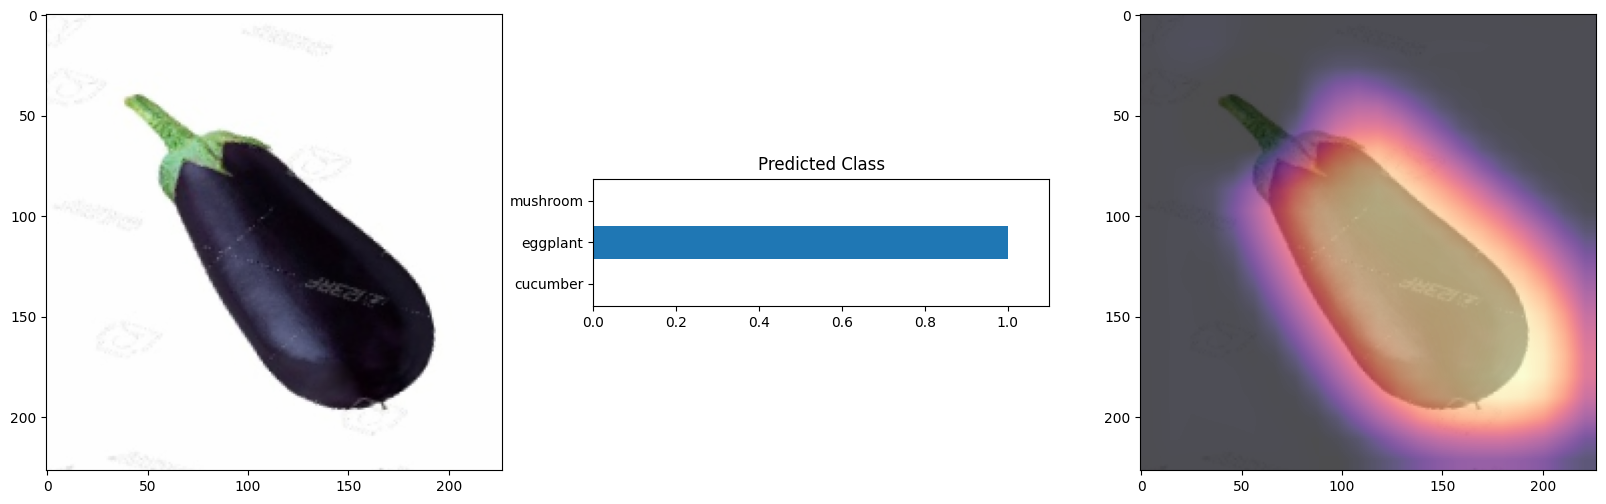

In [104]:
image, label = validset[4]
denorm_image = image.permute(1, 2, 0)*np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456 , 0.406))
image = image.unsqueeze(0).to(DEVICE)

pred = model(image)
heatmap = get_gradcam(model, image, pred[0][1], size = 227)
utils.plot_heatmap(denorm_image, pred, heatmap)